# A Brief Exploration of the English Premier League
## Spanning 8 Seasons (08-16)

This will be an exercise of handling data stored in a database and utilizing python and its various libraries to explore and analyze it. I'm a huge soccer fan so I see myself coming back to this project frequently, exploring further insights, incorporating the player and team attributes, as well as utilizing the gambling data for this or a seperate analysis. But for now this exercise will serve as a framework for building organized, league tables from this data, with a brief exploration of the EPL tables over the 8 seasons provided. 

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import statsmodels.api as sm
import seaborn as sns
from IPython.display import display_html
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#  Data source is a SQLite DB. Setting up connection and implementation

path = "C:/Users/marth/Desktop/Data Science Projects/Soccer Database/"
database = path + "european_soccer_database.sqlite"

con = sqlite3.connect(database)

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", con)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [3]:
# Extraction of Countries, Leagues, Matches, and Teams to store into their own seperate DataFrames

countries = pd.read_sql_query('SELECT * FROM Country;', con)
countries.rename(columns={'id':'country_id', 'name':'country'}, inplace=True)

In [4]:
leagues = pd.read_sql_query('SELECT * FROM League;', con)
leagues.rename(columns={'id':'league_id', 'name':'league'}, inplace=True)

In [5]:
matches = pd.read_sql_query('SELECT * FROM Match;', con)
matches = matches[matches.columns[:11]]

In [6]:
teams = pd.read_sql_query('SELECT * FROM Team;', con)

In [7]:
# Creation of master DataFrame containing every match, from every league

master = pd.merge(matches, leagues, on=['league_id', 'country_id'], how='left')
master = pd.merge(master, countries, on='country_id', how='left')

In [8]:
master.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,league,country
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,Belgium Jupiler League,Belgium
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,Belgium Jupiler League,Belgium
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,Belgium Jupiler League,Belgium
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,Belgium Jupiler League,Belgium
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,Belgium Jupiler League,Belgium


In [9]:
# Seperation of unique seasons, leagues

seasons = master.season.unique().tolist()
league_names = leagues['league'].tolist()

In [10]:
# Function that will produce final table for given season, of given league

def build_table(master, teams, league, season):
    cur_master = master[(master['league'] == league) & (master['season'] == season)]
    cur_teams = cur_master['home_team_api_id'].unique()
    cols = ['MP', 'W', 'D', 'L', 'GF', 'GA']
    table = teams[teams['team_api_id'].isin(cur_teams)].copy()
    for _ in cols:
        table[_] = 0
    for _ in cur_master.index:
        cur = cur_master.loc[_]
        home_team = table['team_api_id'] == cur['home_team_api_id']
        away_team = table['team_api_id'] == cur['away_team_api_id']
        
        table.loc[home_team, 'MP'] += 1
        table.loc[away_team, 'MP'] += 1
        
        home_goals = cur['home_team_goal']
        away_goals = cur['away_team_goal']
        
        table.loc[home_team, 'GF'] += home_goals
        table.loc[home_team, 'GA'] += away_goals
        table.loc[away_team, 'GF'] += away_goals
        table.loc[away_team, 'GA'] += home_goals
        
        if home_goals == away_goals:
            table.loc[home_team, 'D'] += 1
            table.loc[away_team, 'D'] += 1
        elif home_goals > away_goals:
            table.loc[home_team, 'W'] += 1
            table.loc[away_team, 'L'] += 1
        else:
            table.loc[home_team, 'L'] += 1
            table.loc[away_team, 'W'] += 1
            
        table['GD'] = table['GF'] - table['GA']
        table['Points'] = 3 * table['W'] + table['D']
        table.sort_values(['Points', 'GD', 'GF', 'GA'], ascending=False, inplace=True)
        table.index = range(1, len(table) + 1)
               
    return table

In [11]:
# Function to drop columns that are no longer needed

def change_columns(table):
    table = table.drop(columns=['id', 'team_api_id', 'team_fifa_api_id', 'team_short_name'])
    table = table.rename(columns={'team_long_name':'Team'})
    return table

In [12]:
# Function to simplify implementation of above

def final_table(season):
    table = build_table(master, teams, 'England Premier League', season)
    table = change_columns(table)
    return table

EPL_08_09 = final_table(seasons[0])
EPL_09_10 = final_table(seasons[1])
EPL_10_11 = final_table(seasons[2])
EPL_11_12 = final_table(seasons[3])
EPL_12_13 = final_table(seasons[4])
EPL_13_14 = final_table(seasons[5])
EPL_14_15 = final_table(seasons[6])
EPL_15_16 = final_table(seasons[7])

In [13]:
# Function overwriting html in order to visualize tables side by side

def table_display(dfs, names=[]):
    html_str = ''
    if names:
        html_str += '<tr>' + ''.join(f'<td style="text-align:center">{name}</td>' for name in names) + '</tr>'
        html_str += '<tr>' + ''.join(f'<td style="vertical-align:top">{df.to_html(index=False)}</td>' for df in dfs) + '</tr>'
        html_str = f'<table>{html_str}</table>'
        html_str = html_str.replace('table','table style="display:inline"')
    display_html(html_str, raw=True)
    
table_display((EPL_08_09, EPL_09_10, EPL_10_11, EPL_11_12, EPL_12_13, EPL_13_14, EPL_14_15, EPL_15_16),
              ['Premier League 2008-2009', 'Premier League 2009-2010', 'Premier League 2010-2011',
               'Premier League 2011-2012', 'Premier League 2012-2013', 'Premier League 2013-2014',
               'Premier League 2014-2015', 'Premier League 2015-2016'])

Premier League 2008-2009 Premier League 2009-2010 Premier League 2010-2011 Premier League 2011-2012 Premier League 2012-2013 Premier League 2013-2014 Premier League 2014-2015 Premier League 2015-2016 
 
 
 Team 
 MP 
 W 
 D 
 L 
 GF 
 GA 
 GD 
 Points 
 
 
 
 
 Manchester United 
 38 
 28 
 6 
 4 
 68 
 24 
 44 
 90 
 
 
 Liverpool 
 38 
 25 
 11 
 2 
 77 
 27 
 50 
 86 
 
 
 Chelsea 
 38 
 25 
 8 
 5 
 68 
 24 
 44 
 83 
 
 
 Arsenal 
 38 
 20 
 12 
 6 
 68 
 37 
 31 
 72 
 
 
 Everton 
 38 
 17 
 12 
 9 
 55 
 37 
 18 
 63 
 
 
 Aston Villa 
 38 
 17 
 11 
 10 
 54 
 48 
 6 
 62 
 
 
 Fulham 
 38 
 14 
 11 
 13 
 39 
 34 
 5 
 53 
 
 
 Tottenham Hotspur 
 38 
 14 
 9 
 15 
 45 
 45 
 0 
 51 
 
 
 West Ham United 
 38 
 14 
 9 
 15 
 42 
 45 
 -3 
 51 
 
 
 Manchester City 
 38 
 15 
 5 
 18 
 58 
 50 
 8 
 50 
 
 
 Wigan Athletic 
 38 
 12 
 9 
 17 
 34 
 45 
 -11 
 45 
 
 
 Stoke City 
 38 
 12 
 9 
 17 
 38 
 55 
 -17 
 45 
 
 
 Bolton Wanderers 
 38 
 11 
 8 
 19 
 41 
 53 
 -12 
 41 
 
 
 Portsmouth 
 38 
 10 
 11 
 17 
 38 
 57 
 -19 
 41 
 
 
 Blackburn Rovers 
 38 
 10 
 11 
 17 
 40 
 60 
 -20 
 41 
 
 
 Sunderland 
 38 
 9 
 9 
 20 
 34 
 54 
 -20 
 36 
 
 
 Hull City 
 38 
 8 
 11 
 19 
 39 
 64 
 -25 
 35 
 
 
 Newcastle United 
 38 
 7 
 13 
 18 
 40 
 59 
 -19 
 34 
 
 
 Middlesbrough 
 38 
 7 
 11 
 20 
 28 
 57 
 -29 
 32 
 
 
 West Bromwich Albion 
 38 
 8 
 8 
 22 
 36 
 67 
 -31 
 32 
 
 
 
 
 
 Team 
 MP 
 W 
 D 
 L 
 GF 
 GA 
 GD 
 Points 
 
 
 
 
 Chelsea 
 38 
 27 
 5 
 6 
 103 
 32 
 71 
 86 
 
 
 Manchester United 
 38 
 27 
 4 
 7 
 86 
 28 
 58 
 85 
 
 
 Arsenal 
 38 
 23 
 6 
 9 
 83 
 41 
 42 
 75 
 
 
 Tottenham Hotspur 
 38 
 21 
 7 
 10 
 67 
 41 
 26 
 70 
 
 
 Manchester City 
 38 
 18 
 13 
 7 
 73 
 45 
 28 
 67 
 
 
 Aston Villa 
 38 
 17 
 13 
 8 
 52 
 39 
 13 
 64 
 
 
 Liverpool 
 38 
 18 
 9 
 11 
 61 
 35 
 26 
 63 
 
 
 Everton 
 38 
 16 
 13 
 9 
 60 
 49 
 11 
 61 
 
 
 Birmingham City 
 38 
 13 
 11 
 14 
 38 
 47 
 -9 
 50 
 
 
 Blackburn Rovers 
 38 
 13 
 11 
 14 
 41 
 55 
 -14 
 50 
 
 
 Stoke City 
 38 
 11 
 14 
 13 
 34 
 48 
 -14 
 47 
 
 
 Fulham 
 38 
 12 
 10 
 16 
 39 
 46 
 -7 
 46 
 
 
 Sunderland 
 38 
 11 
 11 
 16 
 48 
 56 
 -8 
 44 
 
 
 Bolton Wanderers 
 38 
 10 
 9 
 19 
 42 
 67 
 -25 
 39 
 
 
 Wolverhampton Wanderers 
 38 
 9 
 11 
 18 
 32 
 56 
 -24 
 38 
 
 
 Wigan Athletic 
 38 
 9 
 9 
 20 
 37 
 79 
 -42 
 36 
 
 
 West Ham United 
 38 
 8 
 11 
 19 
 47 
 66 
 -19 
 35 
 
 
 Burnley 
 38 
 8 
 6 
 24 
 42 
 82 
 -40 
 30 
 
 
 Hull City 
 38 
 6 
 12 
 20 
 34 
 75 
 -41 
 30 
 
 
 Portsmouth 
 38 
 7 
 7 
 24 
 34 
 66 
 -32 
 28 
 
 
 
 
 
 Team 
 MP 
 W 
 D 
 L 
 GF 
 GA 
 GD 
 Points 
 
 
 
 
 Manchester United 
 38 
 23 
 11 
 4 
 78 
 37 
 41 
 80 
 
 
 Chelsea 
 38 
 21 
 8 
 9 
 69 
 33 
 36 
 71 
 
 
 Manchester City 
 38 
 21 
 8 
 9 
 60 
 33 
 27 
 71 
 
 
 Arsenal 
 38 
 19 
 11 
 8 
 72 
 43 
 29 
 68 
 
 
 Tottenham Hotspur 
 38 
 16 
 14 
 8 
 55 
 46 
 9 
 62 
 
 
 Liverpool 
 38 
 17 
 7 
 14 
 59 
 44 
 15 
 58 
 
 
 Everton 
 38 
 13 
 15 
 10 
 51 
 45 
 6 
 54 
 
 
 Fulham 
 38 
 11 
 16 
 11 
 49 
 43 
 6 
 49 
 
 
 Aston Villa 
 38 
 12 
 12 
 14 
 48 
 59 
 -11 
 48 
 
 
 Sunderland 
 38 
 12 
 11 
 15 
 45 
 56 
 -11 
 47 
 
 
 West Bromwich Albion 
 38 
 12 
 11 
 15 
 56 
 71 
 -15 
 47 
 
 
 Newcastle United 
 38 
 11 
 13 
 14 
 56 
 57 
 -1 
 46 
 
 
 Stoke City 
 38 
 13 
 7 
 18 
 46 
 48 
 -2 
 46 
 
 
 Bolton Wanderers 
 38 
 12 
 10 
 16 
 52 
 56 
 -4 
 46 
 
 
 Blackburn Rovers 
 38 
 11 
 10 
 17 
 46 
 59 
 -13 
 43 
 
 
 Wigan Athletic 
 38 
 9 
 15 
 14 
 40 
 61 
 -21 
 42 
 
 
 Wolverhampton Wanderers 
 38 
 11 
 7 
 20 
 46 
 66 
 -20 
 40 
 
 
 Birmingham City 
 38 
 8 
 15 
 15 
 37 
 58 
 -21 
 39 
 
 
 Blackpool 
 38 
 10 
 9 
 19 
 55 
 78 
 -23 
 39 
 
 
 West Ham United 
 38 
 7 
 12 
 19 
 43 
 70 
 -27 
 33 
 
 
 
 
 
 Team 
 MP 
 W 
 D 
 L 
 GF 
 GA 
 GD 
 Points 
 
 
 
 
 Manchester City 
 3

In [14]:
# Writing corresponding season variables before consolidating into master EPL DataFrame

EPL_08_09['Season'] = '08-09'
EPL_09_10['Season'] = '09-10'
EPL_10_11['Season'] = '10-11'
EPL_11_12['Season'] = '11-12'
EPL_12_13['Season'] = '12-13'
EPL_13_14['Season'] = '13-14'
EPL_14_15['Season'] = '14-15'
EPL_15_16['Season'] = '15-16'

master_EPL = pd.concat([EPL_08_09, EPL_09_10, EPL_10_11, EPL_11_12, EPL_12_13, EPL_13_14, EPL_14_15, EPL_15_16])

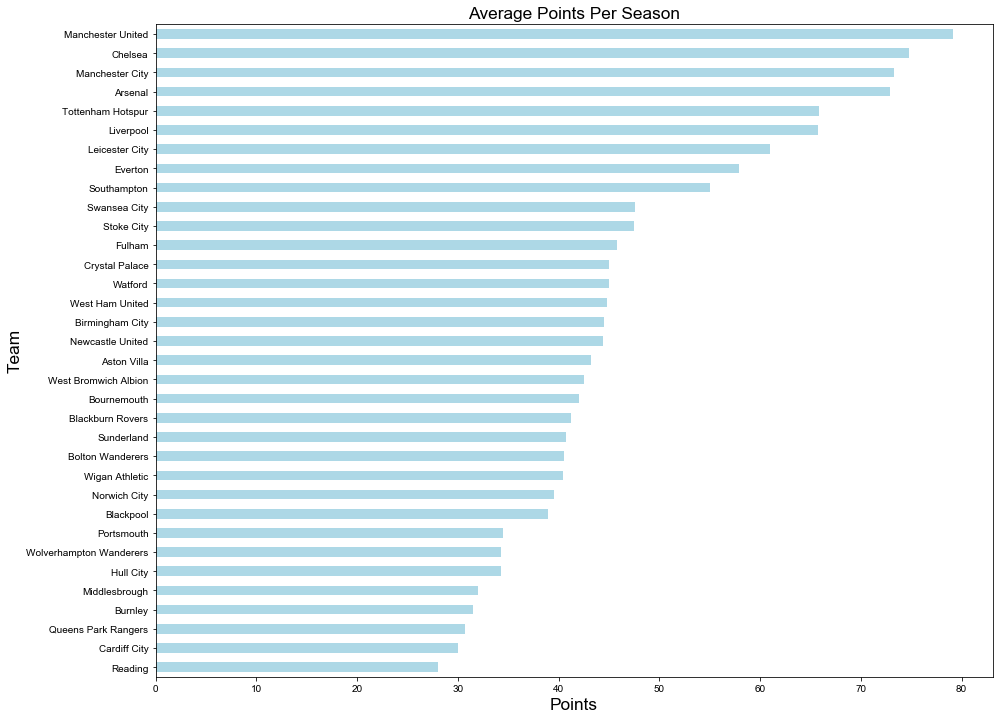

In [15]:
# Plotting average points for each team

master_EPL.groupby('Team')['Points'].mean().sort_values().plot(kind='barh', figsize=(15,12), color='lightblue')
plt.title('Average Points Per Season', fontsize='xx-large')
plt.xlabel('Points', fontsize='xx-large');
plt.ylabel('Team', fontsize='xx-large')
plt.style.use('seaborn-darkgrid')

>Now let's create tables with the averages for goals for, against, and the differential, all on one bar chart. Then we'll focus on the "Big 6" and take a look at how each team perfmormed over time, as well as run regression models for the entire league, seeing which variable is more conducive to higher pont totals; goals for or against.

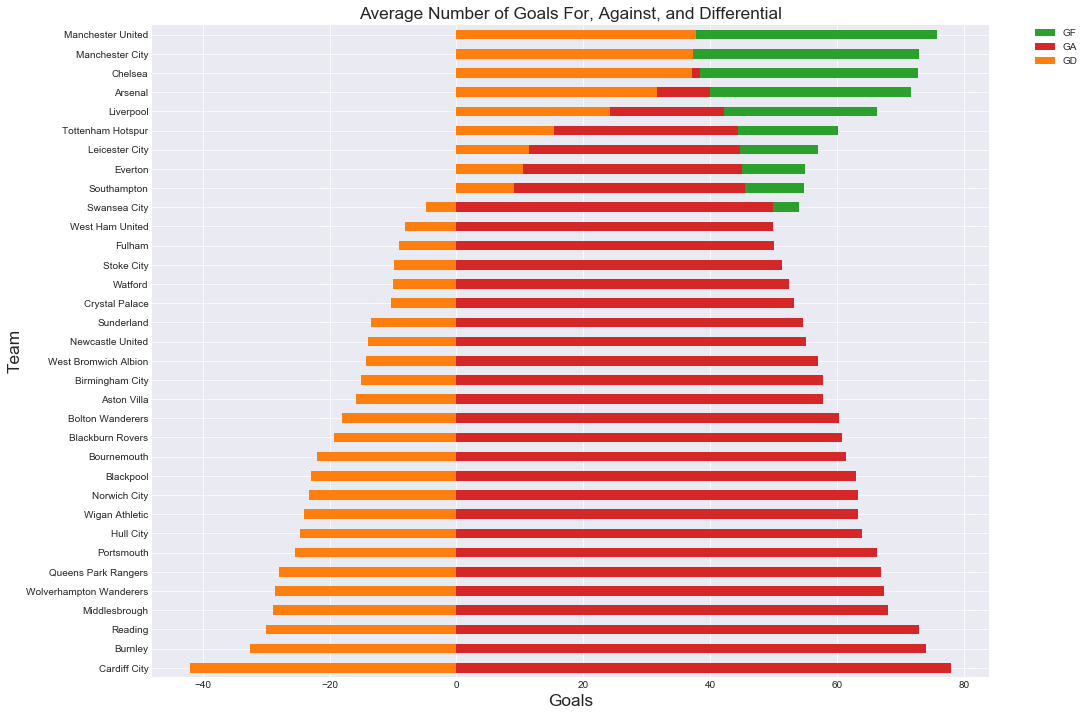

In [16]:
# Calculating and plotting average goals for, against, and differential

gf_avgs = master_EPL.groupby('Team')['GF'].mean().sort_values()
ga_avgs = master_EPL.groupby('Team')['GA'].mean().sort_values(ascending=False)
gd_avgs = master_EPL.groupby('Team')['GD'].mean().sort_values()

ax = gf_avgs.plot(x='GF', y='Team', kind='barh', color='C2', zorder=2, figsize=(15, 12))
ga_avgs.plot(x='GA', y='Team', kind='barh', ax=ax, color='C3', zorder=3)
gd_avgs.plot(x='GD', y='Team', kind='barh', ax=ax, color='C1', zorder=4)

plt.xlabel('Goals', fontsize='xx-large')
plt.ylabel('Team', fontsize='xx-large')
plt.title('Average Number of Goals For, Against, and Differential', fontsize='xx-large')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [17]:
# Extraction of stats for the Big 6 

liv = master_EPL.query('Team == "Liverpool"')
mun = master_EPL.query('Team == "Manchester United"')
mci = master_EPL.query('Team == "Manchester City"')
ars = master_EPL.query('Team == "Arsenal"')
che = master_EPL.query('Team == "Chelsea"')
tot = master_EPL.query('Team == "Tottenham Hotspur"')

big6 = pd.concat([liv, mun, mci, ars, che, tot])

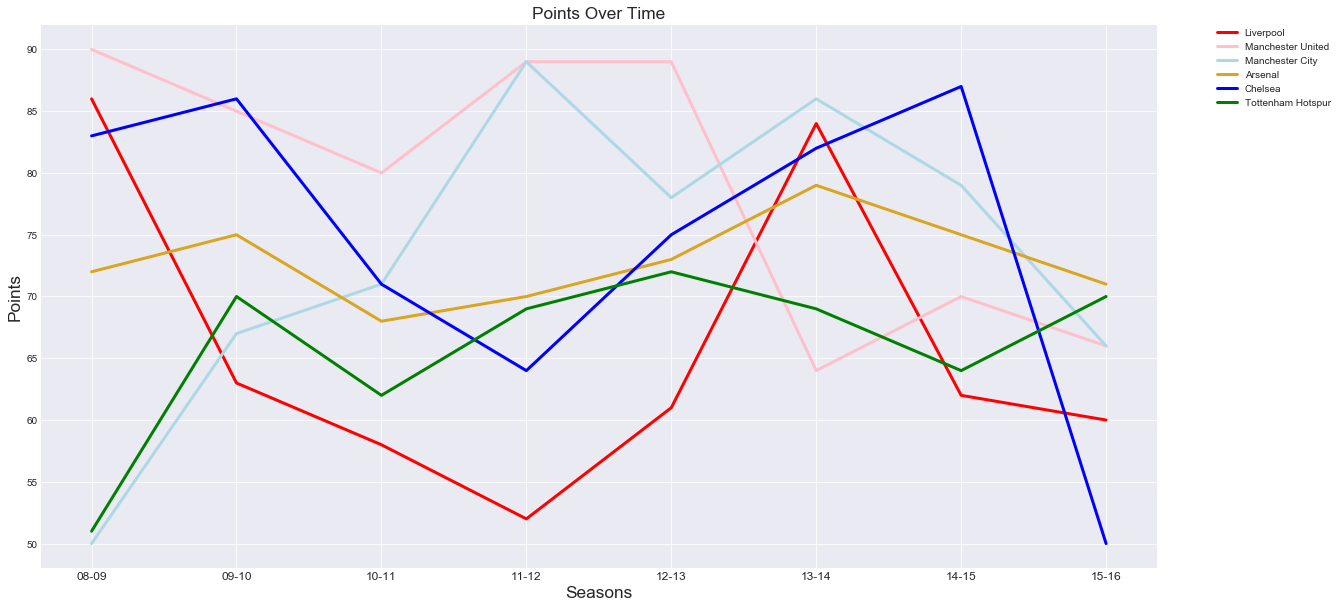

In [18]:
# Plotting total points for all seasons to see perfomance over time

ax = big6.query('Team == "Liverpool"').plot(x='Season', y='Points', figsize=(20, 10), label='Liverpool', color='red', linewidth=3)
big6.query('Team == "Manchester United"').plot(x='Season', y='Points', ax=ax, label='Manchester United', color='pink', linewidth=3)
big6.query('Team == "Manchester City"').plot(x='Season', y='Points', ax=ax, label='Manchester City', color='lightblue', linewidth=3)
big6.query('Team == "Arsenal"').plot(x='Season', y='Points', ax=ax, label='Arsenal', color='goldenrod', linewidth=3)
big6.query('Team == "Chelsea"').plot(x='Season', y='Points', ax=ax, label='Chelsea', color='blue', linewidth=3)
big6.query('Team == "Tottenham Hotspur"').plot(x='Season', y='Points', ax=ax, label='Tottenham Hotspur', color='green', linewidth=3)

x = ['', '08-09', '09-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16']
plt.xlabel('Seasons', fontsize='xx-large')
ax.set_xticklabels(x, fontsize='large')
plt.ylabel('Points', fontsize='xx-large')
plt.title('Points Over Time', fontsize='xx-large')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);

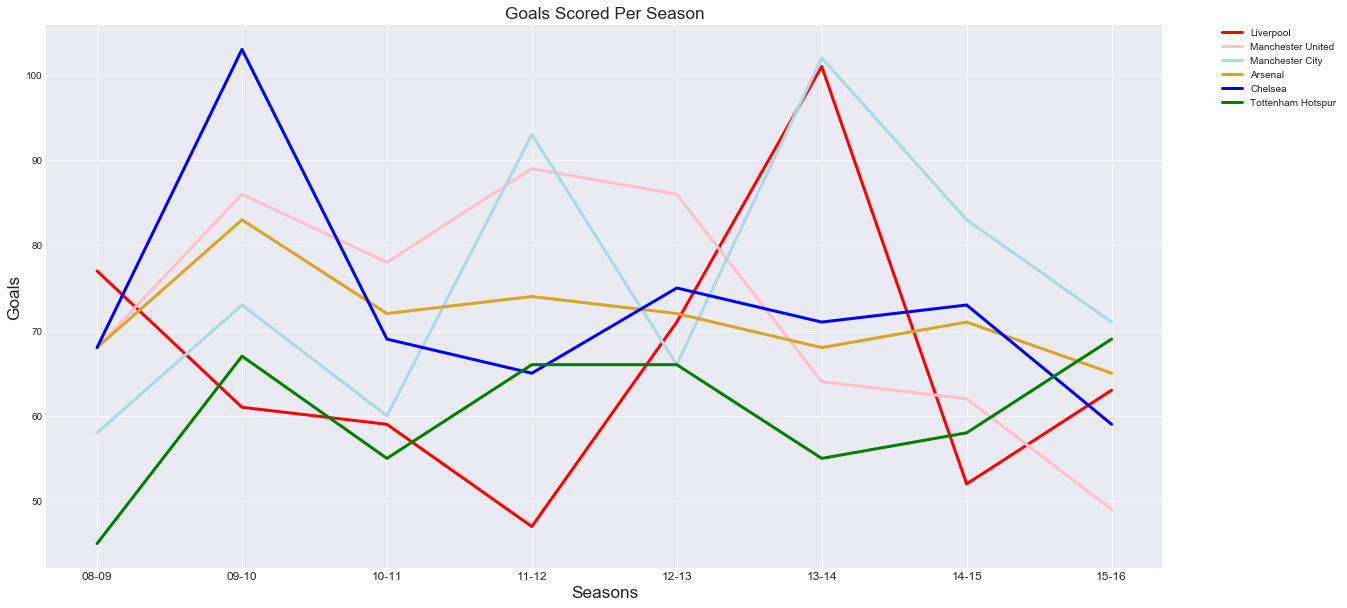

In [19]:
# Total goals scored...

ax = big6.query('Team == "Liverpool"').plot(x='Season', y='GF', figsize=(20, 10), label='Liverpool', color='red', linewidth=3)
big6.query('Team == "Manchester United"').plot(x='Season', y='GF', ax=ax, label='Manchester United', color='pink', linewidth=3)
big6.query('Team == "Manchester City"').plot(x='Season', y='GF', ax=ax, label='Manchester City', color='lightblue', linewidth=3)
big6.query('Team == "Arsenal"').plot(x='Season', y='GF', ax=ax, label='Arsenal', color='goldenrod', linewidth=3)
big6.query('Team == "Chelsea"').plot(x='Season', y='GF', ax=ax, label='Chelsea', color='blue', linewidth=3)
big6.query('Team == "Tottenham Hotspur"').plot(x='Season', y='GF', ax=ax, label='Tottenham Hotspur', color='green', linewidth=3)

x = ['', '08-09', '09-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16']
plt.xlabel('Seasons', fontsize='xx-large')
ax.set_xticklabels(x, fontsize='large')
plt.ylabel('Goals', fontsize='xx-large')
plt.title('Goals Scored Per Season', fontsize='xx-large')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);

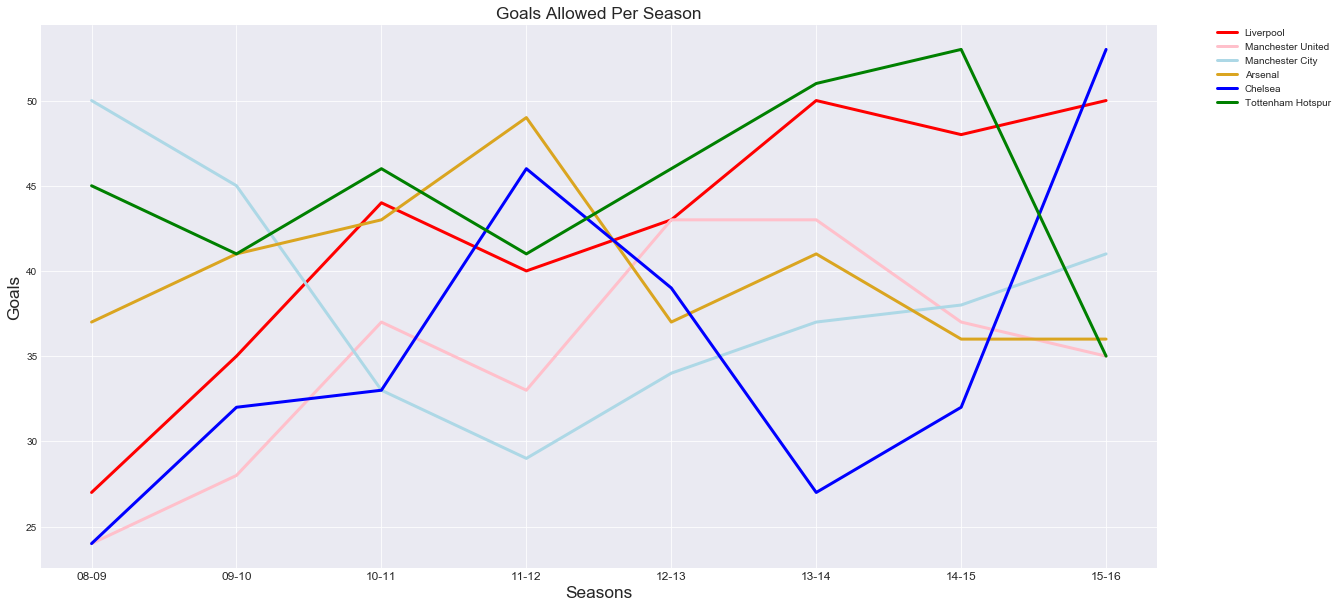

In [20]:
#Total goals against...

ax = big6.query('Team == "Liverpool"').plot(x='Season', y='GA', figsize=(20, 10), label='Liverpool', color='red', linewidth=3)
big6.query('Team == "Manchester United"').plot(x='Season', y='GA', ax=ax, label='Manchester United', color='pink', linewidth=3)
big6.query('Team == "Manchester City"').plot(x='Season', y='GA', ax=ax, label='Manchester City', color='lightblue', linewidth=3)
big6.query('Team == "Arsenal"').plot(x='Season', y='GA', ax=ax, label='Arsenal', color='goldenrod', linewidth=3)
big6.query('Team == "Chelsea"').plot(x='Season', y='GA', ax=ax, label='Chelsea', color='blue', linewidth=3)
big6.query('Team == "Tottenham Hotspur"').plot(x='Season', y='GA', ax=ax, label='Tottenham Hotspur', color='green', linewidth=3)

x = ['', '08-09', '09-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16']
plt.xlabel('Seasons', fontsize='xx-large')
ax.set_xticklabels(x, fontsize='large')
plt.ylabel('Goals', fontsize='xx-large')
plt.title('Goals Allowed Per Season', fontsize='xx-large')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);

In [21]:
# Regression models to test for correlation between both goals for and against with total points

master_EPL['intercept'] = 1

logit = sm.OLS(master_EPL['Points'], master_EPL[['intercept', 'GA']])
results = logit.fit()

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     364.6
Date:                Sat, 22 Sep 2018   Prob (F-statistic):           6.86e-43
Time:                        16:40:21   Log-Likelihood:                -581.02
No. Observations:                 160   AIC:                             1166.
Df Residuals:                     158   BIC:                             1172.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    107.9123      3.012     35.832      0.0

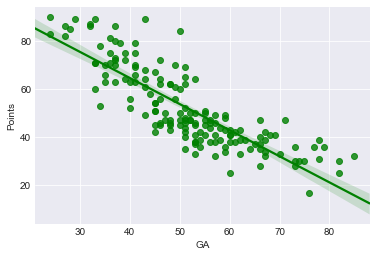

In [22]:
print(results.summary())
sns.regplot(master_EPL['GA'], master_EPL['Points'], fit_reg=True, color='green');
print('correlation: ', master_EPL['Points'].corr(master_EPL['GA']))

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     583.6
Date:                Sat, 22 Sep 2018   Prob (F-statistic):           6.36e-55
Time:                        16:40:22   Log-Likelihood:                -553.02
No. Observations:                 160   AIC:                             1110.
Df Residuals:                     158   BIC:                             1116.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.5162      2.102      1.673      0.0

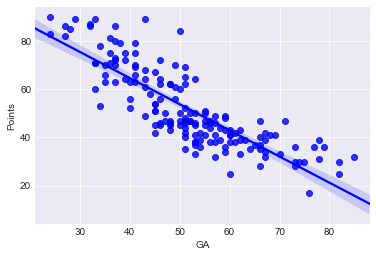

In [23]:
logit = sm.OLS(master_EPL['Points'], master_EPL[['intercept', 'GF']])
results = logit.fit()

print(results.summary())
sns.regplot(master_EPL['GA'], master_EPL['Points'], fit_reg=True, color='blue');
print('correlation: ', master_EPL['Points'].corr(master_EPL['GF']))

>So does offense or defense win championships? While the number of goals a team scores and concedes obviously influences their overall success, the above models suggest goals scored has a _slightly_ stonger correlation to a team's success than goals allowed. However, this is a small sample size and I would be curious to see the results of a much longer study, spanning several decades. <br><br>
But for future analyses of this dataset, I look forward to exploring the player and team attribute tables for correlation, as well as utilizing the gambling odds for match prediction models.